In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
import IPython.display as ipd
import random
import ast
import keras
import tensorflow as tf

from pandas.api.types import CategoricalDtype
from collections import Counter
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from pandas.api.types import CategoricalDtype
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from scipy.stats.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
#df = pd.read_csv('nn.csv', index_col=0)
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [3]:
df = df[df.TRACK_genre_top.isna() == False]

In [4]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
df['target']=[1 if genre == 'Rock' else 0 for genre in df['TRACK_genre_top']]

In [7]:
class_name = 'target'

attributes = Diff(compl + features, [class_name])
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = X_train
y_res = y_train

#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

#rus = RandomUnderSampler(random_state=42)
#X_val, y_val = rus.fit_resample(X_val, y_val)



scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler.fit(X_res)
X_res = scaler.transform(X_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



unique, counts = np.unique(y_train, return_counts=True)
print("train", dict(zip(unique, counts)))

unique, counts = np.unique(y_res, return_counts=True)
print("bilanciato", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("validation", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("test", dict(zip(unique, counts)))


#Trasformo la target value in vettore con 1 sulla posizione del genere giusto
#y_res = tf.keras.utils.to_categorical(y_res, 10)
#y_val = tf.keras.utils.to_categorical(y_val, 10)
#y_test = tf.keras.utils.to_categorical(y_test, 10)

train {0: 28451, 1: 11461}
bilanciato {0: 28451, 1: 11461}
validation {0: 3157, 1: 1278}
test {0: 3512, 1: 1416}


In [8]:
# FUNZIONI PER COSTRUIRE LA NN
def costruisci(n_layer_crescenti=5, initialHiddenLayer=128, n_layer_decrescenti = 5, finalHiddenLayer=128):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    
    for n in range(1, n_layer_crescenti+1):
        model.add(Dense(initialHiddenLayer*(n), activation='relu'))
        print("creo layer crescente di dimensione ", initialHiddenLayer*(n))
    for n in range(n_layer_decrescenti , 0, -1): #CODICE DEI TEST: for n in range(n_layer_decrescenti, 0, -1):
        model.add(Dense(finalHiddenLayer*(n), activation='relu'))
        print("creo layer decrescente di dimensione ", finalHiddenLayer*(n))
        
    model.add(Dense(1, activation=tf.nn.sigmoid))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
    
    return model

In [13]:
model = costruisci(n_layer_crescenti=2, n_layer_decrescenti=2)

es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


history1 = model.fit(X_res, y_res, epochs=1000, 
                      #batch_size= 200,
                      validation_data=(X_val, y_val), callbacks=[es,mc]
                     ).history

creo layer crescente di dimensione  128
creo layer crescente di dimensione  256
creo layer decrescente di dimensione  256
creo layer decrescente di dimensione  128
Epoch 1/1000
1248/1248 [==============================] - 3s 2ms/step - loss: 0.3425 - accuracy: 0.8589 - val_loss: 0.3050 - val_accuracy: 0.8825
Epoch 2/1000
1248/1248 [==============================] - 3s 2ms/step - loss: 0.3029 - accuracy: 0.8774 - val_loss: 0.3096 - val_accuracy: 0.8767
Epoch 3/1000
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2831 - accuracy: 0.8868 - val_loss: 0.2936 - val_accuracy: 0.8888
Epoch 4/1000
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2677 - accuracy: 0.8925 - val_loss: 0.2878 - val_accuracy: 0.8906
Epoch 5/1000
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2529 - accuracy: 0.8988 - val_loss: 0.2883 - val_accuracy: 0.8904
Epoch 6/1000
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2392 - accuracy: 0.9052 - 

In [14]:
y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3512
           1       0.82      0.75      0.79      1416

    accuracy                           0.88      4928
   macro avg       0.86      0.85      0.85      4928
weighted avg       0.88      0.88      0.88      4928



In [406]:
def predictKeras(X):
    prediction_class_1 = model.predict(X) 
    x = np.zeros((prediction_class_1.shape[0], 1))
    probability = (x + 1) - prediction_class_1
    final = np.append(prediction_class_1, probability, axis=1)
    return final

In [407]:
predicted_other = np.where(model.predict_classes(X_test[:100])==1)

In [408]:
predicted_other

(array([ 0, 14, 23, 25, 28, 39, 41, 44, 47, 48, 52, 55, 65, 69, 84, 91, 92,
        94, 98, 99], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64))

In [409]:
rock = np.where(y_test.values[:100]==1)

In [410]:
np.intersect1d(predicted_other, rock) #record rock classificati come other

array([14, 25, 28, 39, 41, 44, 47, 48, 55, 65, 69, 91, 92, 94, 98, 99],
      dtype=int64)

In [411]:
model.predict_classes(X_test[44:45]), y_test.values[44:45]

(array([[1]]), array([1], dtype=int64))

In [466]:
i2e = 98
x = X_test[i2e]

x

array([-0.05116824, -0.98326692, -0.05872159, -0.25005062, -0.13456514,
       -0.74578181, -0.76905832, -0.07130388,  1.11252795,  1.44952817,
        0.38101902, -0.32668102,  0.85484645, -1.05489301, -0.70278442,
       -0.65171199,  0.49675777,  0.19027741,  0.25774988, -0.60082024,
        0.61808269, -0.93611571, -0.62389916, -0.02256821,  0.0152951 ,
       -0.30374881, -0.1322827 , -0.6660341 ,  0.28078863, -0.21750402,
        0.31965411,  0.30001689, -0.12468976, -0.80060175,  0.45989742,
       -0.52435644, -0.93560906,  1.38980991,  0.83027556, -1.58507228,
       -0.14802847,  0.7176146 , -0.40902167, -1.08548827,  0.08384626,
       -0.0647251 ,  0.50656554, -0.30626599, -0.13121575,  0.29732685,
        0.7176146 , -0.43283759,  0.29681868, -1.01243435, -0.32668102,
       -0.14585246, -0.11974763,  0.0033311 ,  0.1435205 ,  0.00220094,
       -0.36998801, -0.04611773,  0.09167727, -0.73618346, -0.02564568,
       -0.3756789 , -0.47149087,  0.07619741, -0.42249073,  1.10

In [467]:
plt.rcParams['figure.dpi'] = 100

# Shap

In [468]:
import shap

shap.initjs()

In [469]:
f = lambda x: predictKeras(x)[:, 0]
med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))

shap_explainer = shap.KernelExplainer(f, med)

In [470]:
shap_values_single = shap_explainer.shap_values(x, nsamples=1000)

In [471]:
shap.force_plot(shap_explainer.expected_value, shap_values_single, features=x, feature_names=attributes)

In [393]:
shap_values = shap_explainer.shap_values(X_test[0:100], nsamples=1000)

KeyboardInterrupt: 

In [231]:
shap.force_plot(shap_explainer.expected_value, shap_values, X_test[0:100,:], feature_names=attributes)

# Lime

In [418]:
from lime.lime_tabular import LimeTabularExplainer

In [434]:
class_values = ['Rock', 'Other']
i2e = 99
x = X_test[i2e]

x

array([-0.05116824, -0.25183141, -0.01725372,  0.18099793, -0.26802192,
       -0.69813025,  1.38023935, -0.03985133,  0.48230603, -1.04491073,
        1.58134849, -0.32668102, -0.641467  , -1.05489301,  0.45478978,
        0.68217844,  0.20851844, -1.16820151,  0.79630227,  0.03764524,
       -0.68096644, -0.30186643, -0.80928378, -0.02863028, -0.15215321,
        0.10813195, -0.15826284, -0.28166883, -0.61692111, -0.53363324,
       -0.39093908, -0.71313652, -0.20861412, -0.23261459, -0.36286408,
        1.33222223,  0.52661705,  0.36121525, -0.8205129 , -0.45135504,
       -0.49377641,  0.53534147,  0.6132847 ,  0.50632978, -0.88904978,
       -0.0647251 , -0.26580225, -0.09691862, -0.04642268, -0.26514892,
        0.53534147,  0.03709762,  0.11495672,  0.99299863, -0.32668102,
       -0.17861753,  0.70036855,  0.35279536, -0.238264  , -0.15087095,
       -0.21220885, -0.65930262, -0.12377393,  0.45983823,  0.0074998 ,
        0.39327047,  1.76978029, -0.03801399, -0.42249073, -0.52

In [435]:
X_test.shape, x.shape, len(attributes)

((4928, 88), (88,), 88)

In [436]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=attributes,
                                      class_names=[str(v) for v in class_values], discretize_continuous=False)

In [437]:
exp = lime_explainer.explain_instance(x, predictKeras)

In [438]:
exp.local_exp

{1: [(9, -0.06287758377681453),
  (38, 0.062380229747504394),
  (20, 0.05779197149222133),
  (15, -0.050747653580873124),
  (29, 0.03982690441945981),
  (18, -0.03101467706108073),
  (10, -0.024978987870597564),
  (17, -0.024119077458007784),
  (66, -0.01900613035941251),
  (6, -0.018865683236986928)]}

In [439]:
exp.show_in_notebook()

# Trepan

In [440]:
from sklearn.tree import DecisionTreeClassifier

In [452]:
y_pred_train = model.predict_classes(X_res)

In [453]:
#y_pred_train = (model.predict(X_train) > 0.5).astype("int32")

In [462]:
explainer = DecisionTreeClassifier(max_depth=4)
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier(max_depth=4)

In [463]:
explainer.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05277468, 0.        , 0.        ,
       0.46090333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03892454, 0.        , 0.        , 0.2317599 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01893579, 0.00506779, 0.        , 0.17959818, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [464]:
import pydotplus
from sklearn import tree
from IPython.display import Image

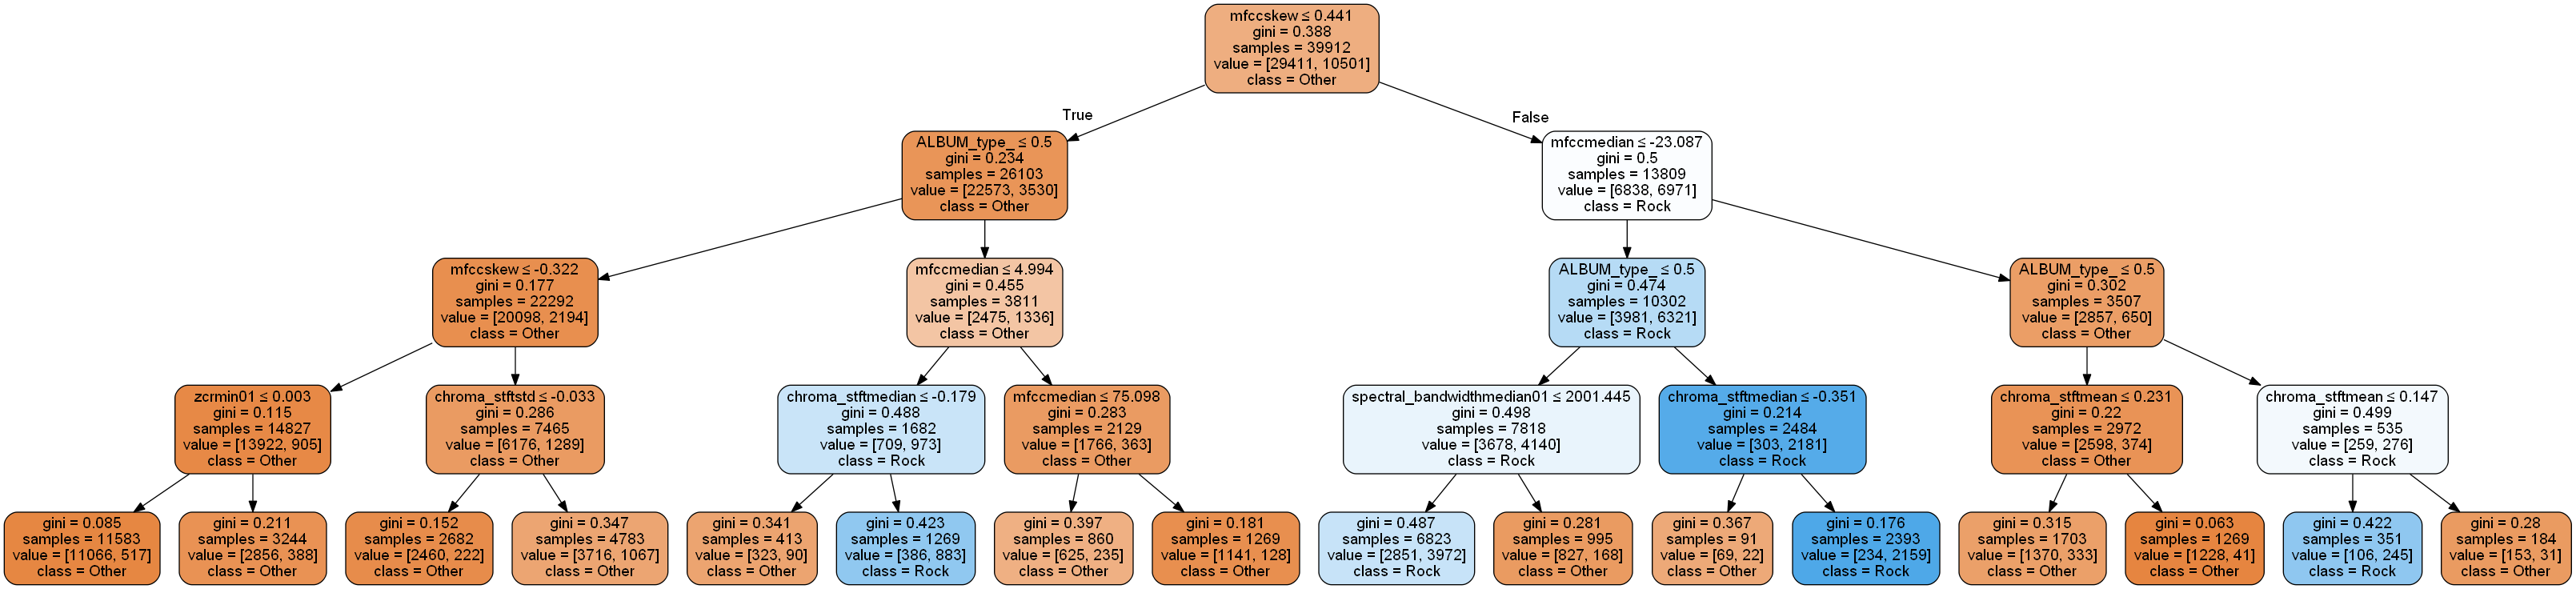

In [465]:
dot_data = tree.export_graphviz(explainer, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Other', 'Rock'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())